In [1]:
from pathlib import Path
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
net_path = Path('..')/'data'/'network_models_shared'
latex_path = Path('..')/'idetc19-latex'/'img'

In [2]:
def set_style():
    # This sets reasonable defaults for font size for a figure that will go in a paper
    sns.set_context("paper")
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    # Make the background white, and specify the specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
set_style()

In [219]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
import lib.loss as loss
from lib.opt import job_minibatch
from lib.invite import sample_censored
from lib.analysis import draw_G, all_thres, Record

note to self for vectorization
```python
T = A/A.sum(axis=1)
a = list(m[0]) + list(set(range(T.shape[0])) - set(m[0]))
idx=5
n = T.shape[0]

a_trans, a_absrb = a[0:idx], a[idx:len(a)-idx]


Q = T[a_trans, :][:, a_trans]
R = T[a_trans, :][:, a_absrb]
I = np.identity(Q.shape[0])

print(Q.shape, R.shape)
P = np.dot(np.linalg.pinv(I-Q), R)
P[-1,0] == P[idx-1, 0]
print(P[idx-1, 0])
Qp = np.pad(Q, (0,n-idx), 
            mode='constant')
Rp = np.pad(R, 
            [(0,n-idx),
             (0,n-len(a_absrb))],
            mode='constant')
print(Qp.shape, Rp.shape)
Pp = np.dot(np.linalg.pinv(np.eye(n)-Qp), Rp)
plt.imshow(Pp)
print(Pp[idx-1, 0])
```

(19, 19) 88.4%


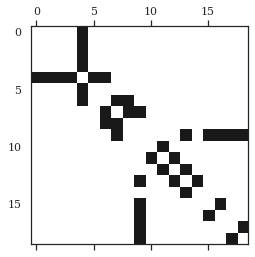

In [176]:
# model='aircraft'
model='drivetrain'
# model='bicycle'
struct = pd.read_excel(net_path/f'{model}_component_model.xlsx', index_col=0)
plt.spy(struct)
print(struct.shape, f'{1-struct.sum().sum()/struct.shape[0]**2:.1%}')

In [177]:
G = nx.from_pandas_adjacency(struct)
G = nx.convert_node_labels_to_integers(G, label_attribute='item')
pos = nx.layout.kamada_kawai_layout(G)
# pos = nx.fruchterman_reingold_layout(G)
# pos = nx.circular_layout(G)

C_β = 0.31


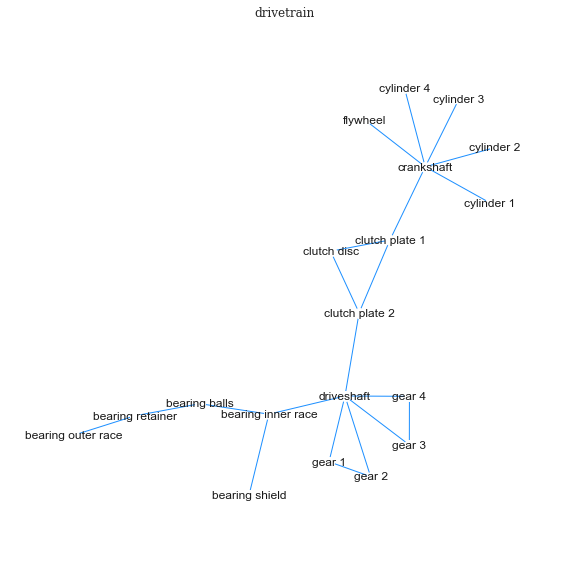

In [179]:
   
print(f'C_β = {nx.average_clustering(G):.2f}')
plt.figure(figsize=(8,8))
# draw_G(G, pos, withlabels=False, title=model)

draw_G(G, pos, withlabels=True, title=model)
plt.tight_layout()
plt.margins(.15)
# plt.savefig(latex_path/f'true_G_{model}.png', dpi=300)

In [180]:
m = sample_censored(G, 50, 5, steps=50)


0 bearing balls → bearing retainer → bearing outer race → bearing inner race → driveshaft
.
.
1 flywheel → crankshaft → cylinder 1 → cylinder 2 → cylinder 3
.
.
2 cylinder 1 → crankshaft → cylinder 4 → cylinder 2 → clutch plate 1
.
.
3 bearing outer race → bearing retainer → bearing balls → bearing inner race → bearing shield
.
.
49 bearing inner race → bearing shield → bearing balls → bearing retainer → bearing outer race


In [181]:
A = nx.to_numpy_array(G)

B = np.random.rand(*A.shape)
B = B.T + B - 2*np.diag(B.diagonal())

# f,ax = plt.subplots(ncols=2)
# ax[0].imshow(B)
# ax[1].imshow(A)

<IPython.core.display.Javascript object>


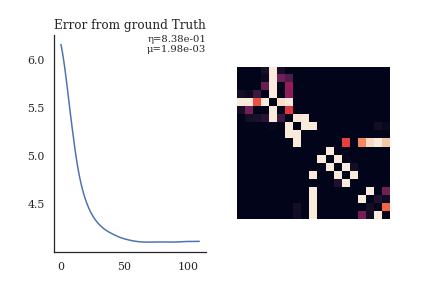

In [315]:
from lib.opt import job_minibatch
%matplotlib notebook

rec = Record(x_true=A)

A_approx = job_minibatch(loss.loss, B, m,
                         epochs=10,
                         learning_rate=0.9,
                         batch_size=5,
                         reg=.01,
                         decay=True,
                         avg=True,
                         callback=rec.err_and_mat)

%matplotlib inline

In [316]:
from sklearn import preprocessing as pre
from sklearn.metrics.pairwise import cosine_similarity
def cosine_model(m, **cos_kws):

    encode = pre.MultiLabelBinarizer()
    tags = encode.fit_transform(m)

    cos = cosine_similarity(tags.T.dot(tags))
    cos -= np.diag(cos.diagonal())
    return cos
cos = cosine_model(m)
    

In [317]:
import pomegranate as pom

def markov_model(m, **pom_kws):
    clf = pom.MarkovChain.from_samples(np.array(m).tolist(), **pom_kws)
    C = pd.DataFrame(clf.distributions[1].parameters[0], 
                     columns=['source', 'target', 'weight'])
    C_g = nx.from_pandas_edgelist(C, edge_attr=True, create_using=nx.DiGraph)
    mkv = nx.to_numpy_array(C_g)
    mkv -= np.diag(mkv.diagonal())
    return mkv

mkv1 = markov_model(m, k=1)
mkv2 = markov_model(m, k=2)

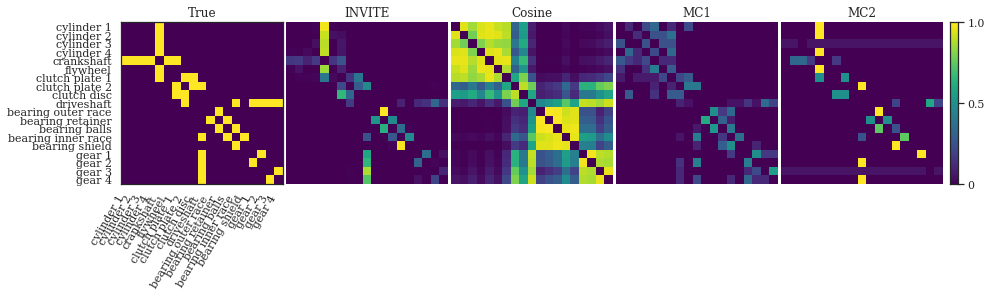

In [318]:
from lib.analysis import compare_mats, compare_pvr

models = dict(
    INVITE=A_approx, 
    Cosine=cos, 
    MC1=mkv1, 
    MC2=mkv2,
)

fig = compare_mats(
    A, 
    labels=struct.columns,
    **models
)
# plt.savefig(latex_path/f'comparison_99x3-{model}', dpi=300)
plt.show()

# sns.heatmap(cos, yticklabels=struct.columns, xticklabels=struct.columns, cmap='viridis')

/home/tbsexton/Documents/Projects/structuring_knowledge/lib/analysis.py:228: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.xlim(0, 1.05)


INVITE APS:	 1.00
Cosine APS:	 0.62
MC1 APS:	 0.70
MC2 APS:	 0.71


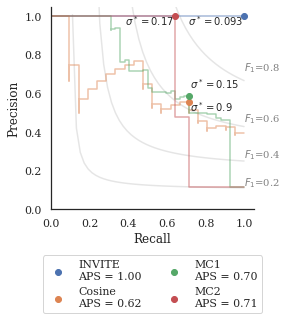

In [319]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, f1_score
from functools import partial
from adjustText import adjust_text


res = compare_pvr(A, **models)
for i in res.items():
    print(f"{i[0]} APS:\t {i[1]['aps']:.2f}")




plt.savefig(f'pvr_3_{model}DEMO.png')


In [234]:
# cos_, mkv1_,mkv2_, ivt_ = (compare_pvr(A, plot=False, **models).get(i) for i in ['Cosine', ])

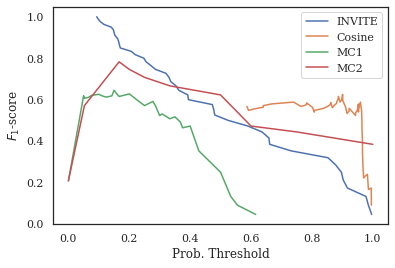

In [320]:
for name, d in res.items():
    plt.plot(d['t'], d['f'], label=name)
    plt.legend(loc=0)
    plt.xlabel('Prob. Threshold')
    plt.ylabel('$F_1$-score')


Threshold = 2.2222e-02


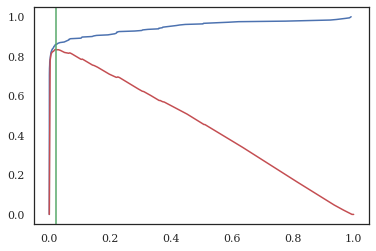

In [282]:
_, A_thres = all_thres(A_approx, pct_thres=None)

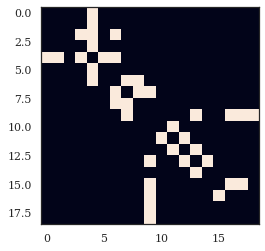

In [283]:
# plt.imshow(A_approx)
A_thres = np.where(A_approx>=res['INVITE']['t'][res['INVITE']['opt_pos']], 1, 0)
plt.imshow(A_thres)
# sns.clustermap(A_thres)

/home/tbsexton/miniconda3/envs/eng-net/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/tbsexton/miniconda3/envs/eng-net/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


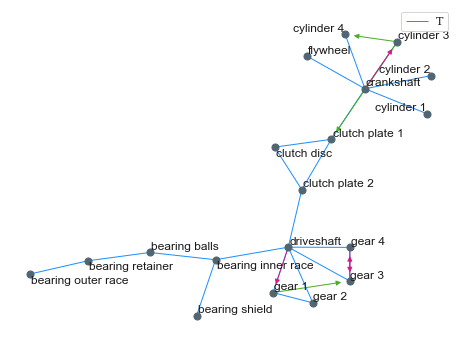

In [284]:
plt.figure(figsize=(8,6))
in_approx     = nx.from_numpy_array(A_thres - A > 0, create_using=nx.DiGraph)
not_in_approx = nx.from_numpy_array(A - A_thres > 0, create_using=nx.DiGraph)

draw_G(G, pos, fp=in_approx, fn=not_in_approx, withlabels=True)


# adjust_text()

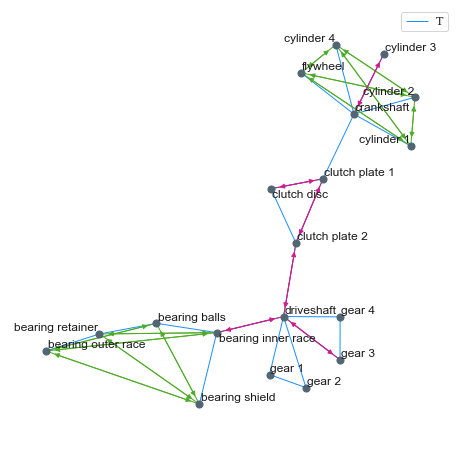

In [286]:
plt.figure(figsize=(8,8))
cos_thres = np.where(cos>=res['Cosine']['t'][res['Cosine']['opt_pos']], 1, 0)
in_cos     = nx.from_numpy_array(cos_thres - A > 0, create_using=nx.DiGraph)
not_in_cos = nx.from_numpy_array(A - cos_thres > 0, create_using=nx.DiGraph)

draw_G(G, pos, fp=in_cos, fn=not_in_cos, withlabels=True)

/home/tbsexton/miniconda3/envs/eng-net/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/tbsexton/miniconda3/envs/eng-net/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


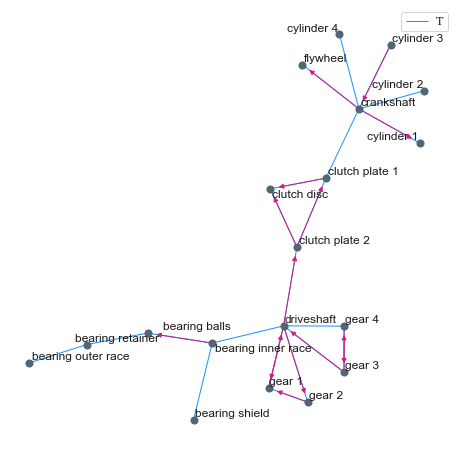

In [321]:
plt.figure(figsize=(8,8))
mkv_thres = np.where(mkv>=res['MC1']['t'][res['MC1']['opt_pos']], 1, 0)
in_mkv     = nx.from_numpy_array(mkv_thres - A > 0, create_using=nx.DiGraph)
not_in_mkv = nx.from_numpy_array(A - mkv_thres > 0, create_using=nx.DiGraph)

draw_G(G, pos, fp=in_mkv, fn=not_in_mkv, withlabels=True)

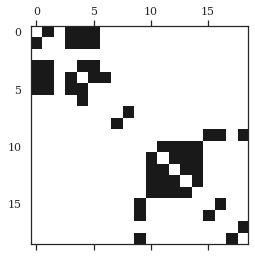

In [287]:
# plt.imshow((cos_thres - A))
# sns.clustermap(cos_thres)
plt.spy(cos_thres)
# res = (cos_thres - A).flatten()
# FP = (res>0).sum()
# FN = (res<0).sum()
# TP = A[A_thres>0].sum()

# p = TP/(TP+FP)
# r = TP/(TP+FN)
# f = 2*p*r/(p+r)
# f, p, r

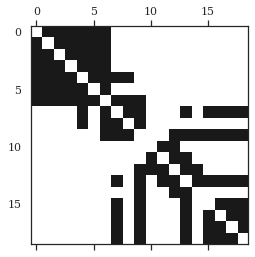

In [288]:
walk2 = nx.to_numpy_array(nx.power(G, 2))
plt.spy(walk2)

/home/tbsexton/miniconda3/envs/eng-net/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/tbsexton/miniconda3/envs/eng-net/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


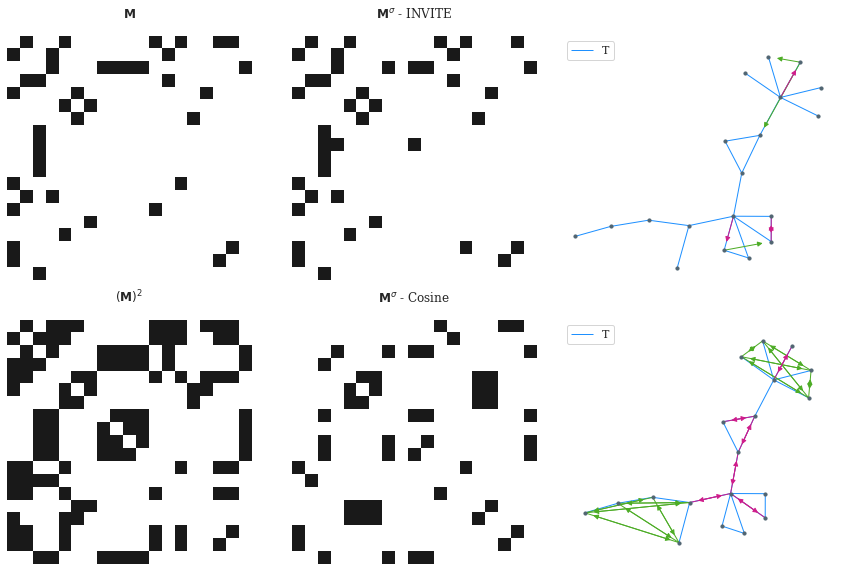

In [290]:
order=(pd.Series(nx.betweenness_centrality(G))
    .sort_values(ascending=False)
    .index.tolist()
)
def sort_spy(A, order, ax=None, **kws):
    if ax is None:
        f = plt.figure()
        ax = plt.gca()
    a = A[order,:][:,order]
    
    ax.spy(a, **kws)

f,axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

for n,ax in enumerate(axes[:,:2].flatten()):
    sort_spy([
        A, 
        A_thres, 
        walk2, 
        cos_thres,
    ][n], order, ax=ax)
    ax.axis('off')
    ax.set_title([
        '$\mathbf{M}$',
        '$\mathbf{M}^{\sigma}$ - INVITE',
        '$(\mathbf{M})^2$',
        '$\mathbf{M}^{\sigma}$ - Cosine',
    ][n])
    
for n, ax in enumerate(axes[:,-1].flatten()):
    plt.axes(ax)
    draw_G(G, pos, **{
        0:dict(fp=in_approx, fn=not_in_approx),
        1:dict(fp=in_cos, fn=not_in_cos)
    }[n])
plt.tight_layout()
plt.savefig(latex_path/'powergraph-compare.png')

# OLD

In [100]:
# np.savetxt('cosine-adj.txt', cos)
# np.savetxt('ivt-adj.txt', A_approx)
# np.savetxt('ivt-cos-fthres.txt', np.array([ts_ivt, ts_cos]))

ivt = np.loadtxt('ivt-adj.txt')
cos = np.loadtxt('cosine-adj.txt')
np.loadtxt('ivt-cos-fthres.txt')

array([0.00040543, 0.33963532])

/home/tbsexton/anaconda3/envs/eng-net/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/tbsexton/anaconda3/envs/eng-net/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/tbsexton/anaconda3/envs/eng-net/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


0.8888888888888888

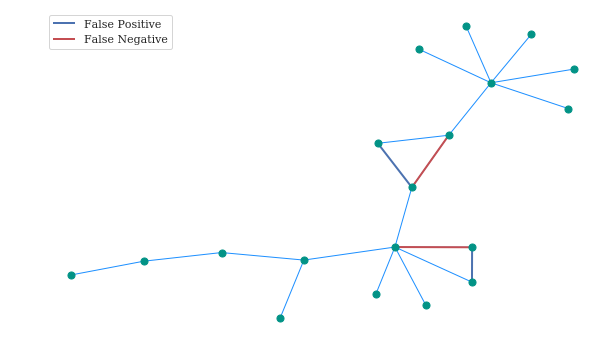

In [248]:
T = nx.maximum_spanning_tree(G)

pathfind = nx.to_numpy_array(nx.maximum_spanning_tree(nx.Graph(A_approx)))
path_thres = np.where(pathfind>0, 1, 0) 

in_path     = nx.from_numpy_array(path_thres - nx.to_numpy_array(T) > 0)
not_in_path = nx.from_numpy_array(nx.to_numpy_array(T) - path_thres > 0)

draw_G(T, pos, fp=in_path, fn=not_in_path, withlabels=False)
# draw_G(pathfind, pos)
f1_score(nx.to_numpy_array(T).flatten(), path_thres.flatten())

/home/tbsexton/anaconda3/envs/eng-net/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/tbsexton/anaconda3/envs/eng-net/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/tbsexton/anaconda3/envs/eng-net/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


0.8333333333333334

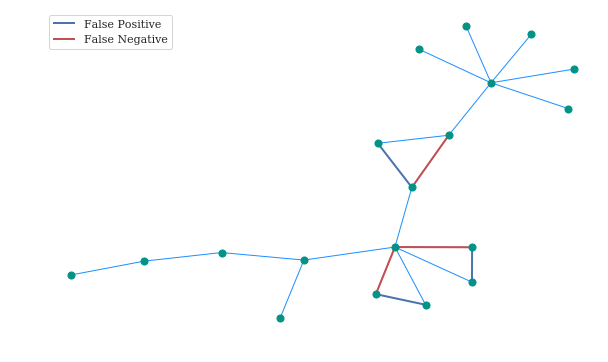

In [249]:
T = nx.maximum_spanning_tree(G)

pathfind = nx.to_numpy_array(nx.maximum_spanning_tree(nx.Graph(cos)))
path_thres = np.where(pathfind>0, 1, 0) 

in_path     = nx.from_numpy_array(path_thres - nx.to_numpy_array(T) > 0)
not_in_path = nx.from_numpy_array(nx.to_numpy_array(T) - path_thres > 0)

draw_G(T, pos, fp=in_path, fn=not_in_path, withlabels=False)
# draw_G(pathfind, pos)
f1_score(nx.to_numpy_array(T).flatten(), path_thres.flatten())

In [250]:
f1_score(A.flatten(), cos_thres.flatten()), f1_score(A.flatten(), A_thres.flatten())

(0.8421052631578947, 0.9879518072289156)

experimental below

In [97]:
def sinkhorn(P):
    """Fit the diagonal matrices in Sinkhorn Knopp's algorithm
    Parameters
    ----------
    P : 2d array-like
    Must be a square non-negative 2d array-like object, that
    is convertible to a numpy array. The matrix must not be
    equal to 0 and it must have total support for the algorithm
    to converge.
    Returns
    -------
    A double stochastic matrix.
    """
    i=0

    N = P.shape[0]
    max_thresh = 1 + 1e-3
    min_thresh = 1 - 1e-3
    _stopping_condition = None
    _iterations = 0
    _D1 = np.ones(1)
    _D2 = np.ones(1)
    # Initialize r and c, the diagonals of D1 and D2
    # and warn if the matrix does not have support.
    r = np.ones((N, 1))
    pdotr = P.T.dot(r)
    total_support_warning_str = (
        "Matrix P must have total support. "
        "See documentation"
    )
    if not np.all(pdotr != 0):
        warnings.warn(total_support_warning_str, UserWarning)

    c = 1 / pdotr
    pdotc = P.dot(c)
    if not np.all(pdotc != 0):
        warnings.warn(total_support_warning_str, UserWarning)

    r = 1 / pdotc
    del pdotr, pdotc

    P_eps = np.copy(P)
    while np.any(np.sum(P_eps, axis=1) < min_thresh) \
            or np.any(np.sum(P_eps, axis=1) > max_thresh) \
            or np.any(np.sum(P_eps, axis=0) < min_thresh) \
            or np.any(np.sum(P_eps, axis=0) > max_thresh):

        c = 1 / P.T.dot(r)
        r = 1 / P.dot(c)

        _D1 = np.diag(np.squeeze(r))
        _D2 = np.diag(np.squeeze(c))
        P_eps = self._D1.dot(P).dot(self._D2)

        self.==_iterations += 1

        if self.==_iterations >= self._max_iter:
            self.==_stopping_condition = "max_iter"
            break
        i+=1
    if not self.==_stopping_condition:
        self.==_stopping_condition = "epsilon"

    self._D1 = np.diag(np.squeeze(r))
    self._D2 = np.diag(np.squeeze(c))
    P_eps = self._D1.dot(P).dot(self._D2)
    print(i)
    return P_eps

sinkhorn(A)

NameError: name 'self' is not defined

In [ ]:
from sklearn import mixture, metrics

pre_thres = lambda a: np.log1p(a)
# pre_thres = lambda a: np.log(a+a.mean())

a =  pre_thres((A/A.sum(axis=1)).flatten())
a_ = pre_thres(A_approx.flatten())

gmm = mixture.BayesianGaussianMixture(n_components=2)
gmm.fit(a_.reshape(-1,1))
real_edge = gmm.predict(a_.reshape(-1,1))

if gmm.means_.argmin() == 1:  # flipped gmm classes
    print('flipping!')
    real_edge = np.where(real_edge==1, 0,1)

A_thres = real_edge.reshape(A.shape)
A_thres -= np.diag(A_thres.diagonal())

a_t = pre_thres((A_thres/A_thres.sum(axis=1)).flatten())


f_score = metrics.fbeta_score(real_edge, A.flatten(), 1.)
print(f'F_1 = {f_score:.3f}')

plt.figure(figsize=(8,3))
plt.subplot(121)    


sns.distplot(a_, norm_hist=True, kde=False)
sns.distplot(a, norm_hist=True, kde=False, color='k', hist_kws={"alpha": .9})
sns.distplot(a_t, 
             norm_hist=True, kde=False, hist_kws={"histtype": "step", 'alpha':1.})

plt.yscale('log')

plt.subplot(122)
sns.heatmap((pre_thres(A_approx)))

In [ ]:
plt.imshow(cos_thres)

In [ ]:
sns.distplot(cos.flatten(), norm_hist=True, kde=False)

gmm = mixture.BayesianGaussianMixture(n_components=2)
gmm.fit(cos.flatten().reshape(-1,1))

real_edge = gmm.predict(cos.flatten().reshape(-1,1))
if gmm.means_.argmin() == 1:  # flipped gmm classes
    print('flipping!')
    real_edge = np.where(real_edge==1, 0,1)
    
f_score = metrics.fbeta_score(real_edge, A.flatten(), 1.)
print(f'F_1 = {f_score:.3f}')

cos_thres = real_edge.reshape(A.shape)
cos_thres -= np.diag(A_thres.diagonal())

# thres = .4
# cos_thres = (cos.flatten()>thres).reshape(A.shape)
# print(metrics.fbeta_score(cos.flatten()>thres, A.flatten(), 1.))